In [2]:
%matplotlib inline

import os
import glob
import imageio

from math import atan2, degrees

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap

from scipy.ndimage import gaussian_filter

# Plot hetmaps over selected frame without data from rejected sessions.

In [3]:
DISPLAY_SIZE = (320,200)
extent = [0, DISPLAY_SIZE[0], DISPLAY_SIZE[1], 0]

cmap = cm.jet
my_cmap = cmap(np.arange(cmap.N))
# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
# Create new colormap
cm_jet = ListedColormap(my_cmap)

def visual_span_from_distance(distance, size=5, scale=1):
    h = 324 / scale # Monitor height in cm
    d = distance / scale # Distance between monitor and participant in cm
    r = 800 / scale # Vertical resolution of the monitor
    size_in_deg = size # The stimulus size in pixels
    # Calculate the number of degrees that correspond to a single pixel. This will
    # generally be a very small value, something like 0.03.
    deg_per_px = degrees(atan2(.5*h, d)) / (.5*r)
    # Calculate the size of the stimulus in degrees
    size_in_px = size_in_deg / deg_per_px
    return size_in_px


def normalize(data):
    return ( data - data.min() ) / ( data.max() - data.min() )

def get_data(mediafile):
    media = imageio.get_reader("../Dataset/Mahnob/data/media_24/{}.avi".format(mediafile))
    
    fixations_heatmaps = None #np.load("data/valence_fixation_heatmap_{}.npz".format(mediafile))['heatmaps']
    valence_emotion_heatmaps = np.load("data/valence_emotion_heatmap_{}.npz".format(mediafile))['heatmaps']
    arousal_emotion_heatmaps = np.load("data/arousal_emotion_heatmap_{}.npz".format(mediafile))['heatmaps']
    
    return media, fixations_heatmaps, valence_emotion_heatmaps, arousal_emotion_heatmaps

def get_media_frame(media, frames):
    images = []
    for frame in frames:
        media.set_image_index(frame-1)
        images.append(media.get_next_data())
    return images


def get_frame_fixations(fix, frames):
    frame_fixations = []
    for frame in frames:
        frame_fixations.append(fix.T[frame-1])
    return frame_fixations

##
## PLOT FUNCTIONS
##

def create_axes(sub=(1,1)):
    
    dpi = 100
    ncols=sub[0]
    nrows=sub[1]
    # determine the figure size in inches
    figsize = (1280*ncols/dpi, 800*nrows/dpi)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi)
    
    extent = [0, DISPLAY_SIZE[0], DISPLAY_SIZE[1], 0]

    if not isinstance(axes, type(np.array)): 
        axes = np.array(axes) 
    
    for ax in axes.flatten(): 
        ax.axis(extent)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    return axes.flatten()

def plot_images(axes, frames):
    images = get_media_frame(media, frames)
    for ax, im in zip(axes, images):
        ax.imshow(im, origin='lower')
    
def plot_heatmap(axes, data, frames):
    for ax, fix in zip(axes, frames):
        heatmap = data[frames]
        print(heatmap.shape)
        ax.imshow(heatmap.squeeze(), extent=extent, cmap=cm_jet, alpha=.8)

In [4]:
mediafile = 53
media, fixation_heatmaps, valence_emotion_heatmaps, arousal_emotion_heatmaps = get_data(mediafile)

In [5]:
print(fixation_heatmaps.shape)
print(valence_emotion_heatmaps.shape)
print(arousal_emotion_heatmaps.shape)

AttributeError: 'NoneType' object has no attribute 'shape'

In [16]:
frames = [200]
col = 1

(1, 200, 320)
(1, 200, 320)


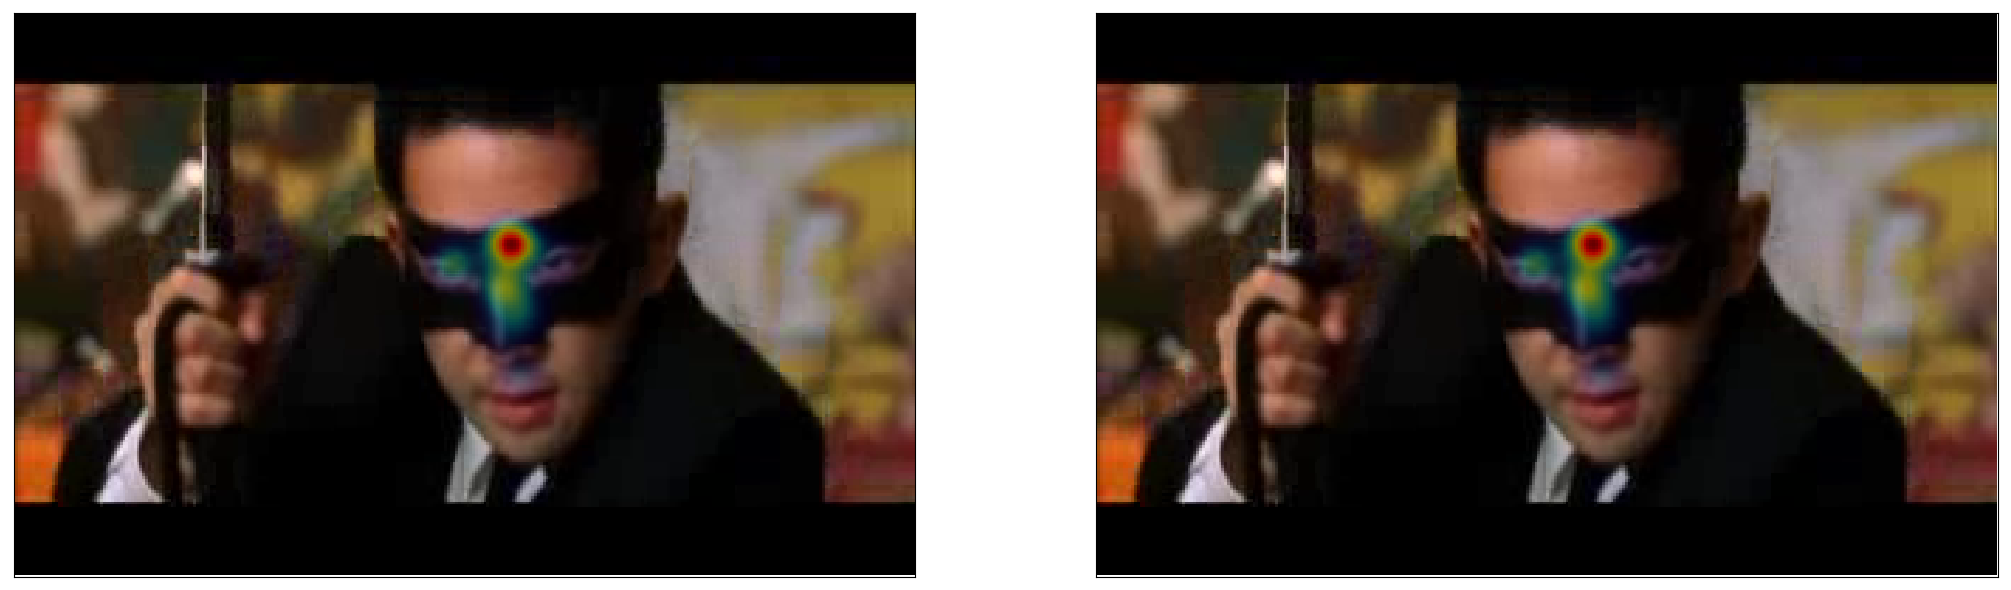

In [17]:
axes = create_axes((2,1))
plot_images([axes[0]], frames)
plot_images([axes[1]], frames)
plot_heatmap([axes[0]], valence_emotion_heatmaps, frames)
plot_heatmap([axes[1]], arousal_emotion_heatmaps, frames)